In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
%matplotlib inline

import pystruct
from pystruct.datasets import load_letters
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split

# Pystruct Chain CRF Example with Letters

https://pystruct.github.io/auto_examples/plot_letters.html

In [2]:
abc = "abcdefghijklmnopqrstuvwxyz"
letters = load_letters()

In [6]:
X, y, folds = letters['data'], letters['labels'], letters['folds']
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [3]:
X, y, folds = letters['data'], letters['labels'], letters['folds']
X, y = np.array(X), np.array(y)
X_train, X_test = X[folds <= 6], X[folds > 6]
y_train, y_test = y[folds <= 6], y[folds > 6]

### Train Linear SVM

In [7]:
# Train linear SVM
svm = LinearSVC(dual=False, C=.1)
# flatten input
svm.fit(np.vstack(X_train), np.hstack(y_train))

LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### Train Linear Chain CRF

In [8]:
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=11)
ssvm.fit(X_train, y_train)

FrankWolfeSSVM(C=0.1, batch_mode=False, check_dual_every=10,
        do_averaging=True, line_search=True, logger=None, max_iter=11,
        model=ChainCRF(n_states: 26, inference_method: max-product),
        n_jobs=1, random_state=None, sample_method='perm',
        show_loss_every=0, tol=0.001, verbose=0)

### Score SVM vs Chain CRF

In [6]:
print("Test score with linear SVM: %f" % svm.score(np.vstack(X_test),
                                                   np.hstack(y_test)))
print("Test score with chain CRF: %f" % ssvm.score(X_test, y_test))

Test score with linear SVM: 0.747901
Test score with chain CRF: 0.849650


### Plotting some word sequences

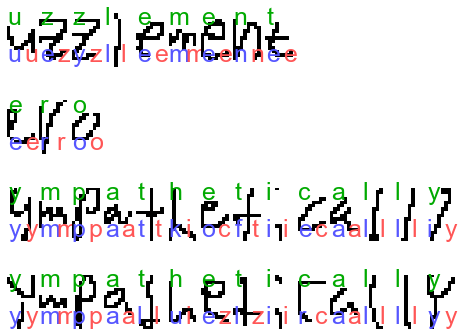

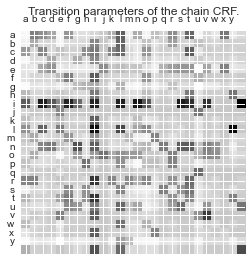

In [7]:
n_words = 4
rnd = np.random.RandomState()
selected = rnd.randint(len(y_test), size=n_words)
max_word_len = max([len(y_) for y_ in y_test[selected]])
fig, axes = plt.subplots(n_words, max_word_len, figsize=(8, 6))
fig.subplots_adjust(wspace=.2)
for ind, axes_row in zip(selected, axes):
    y_pred_svm = svm.predict(X_test[ind])
    y_pred_chain = ssvm.predict([X_test[ind]])[0]
    for i, (a, image, y_true, y_svm, y_chain) in enumerate(
            zip(axes_row, X_test[ind], y_test[ind], y_pred_svm, y_pred_chain)):
        a.matshow(image.reshape(16, 8), cmap=plt.cm.Greys)
        a.text(0, 3, abc[y_true], color="#00AA00", size=25)
        a.text(0, 14, abc[y_svm], color="#5555FF", size=25)
        a.text(5, 14, abc[y_chain], color="#FF5555", size=25)
        a.set_xticks(())
        a.set_yticks(())
    for ii in range(i + 1, max_word_len):
        axes_row[ii].set_visible(False)

plt.matshow(ssvm.w[26 * 8 * 16:].reshape(26, 26))
plt.title("Transition parameters of the chain CRF.")
plt.xticks(np.arange(25), abc)
plt.yticks(np.arange(25), abc)
plt.show()

---

---

---

---

# SVM as CRF

https://pystruct.github.io/auto_examples/svm_as_crf.html

In [104]:
from time import time
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from pystruct.models import GraphCRF
from pystruct.learners import NSlackSSVM

In [126]:
x = X[:4]
print x
print np.atleast_2d(x)
np.empty((0,2), dtype=np.int)

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]]
[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]]


array([], shape=(0, 2), dtype=int64)

In [106]:
iris = load_iris()
X, y = iris.data, iris.target
X_ = [(np.atleast_2d(x), np.empty((0, 2), dtype=np.int)) for x in X]
Y = y.reshape(-1, 1)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_, Y)
pbl = GraphCRF(inference_method='unary')
svm = NSlackSSVM(pbl, C=100)

In [108]:
start = time()
svm.fit(X_train, y_train)
time_svm = time() - start
y_pred = np.vstack(svm.predict(X_test))
print("Score with pystruct crf svm: %f (took %f seconds)"
      % (np.mean(y_pred == y_test), time_svm))

Score with pystruct crf svm: 0.973684 (took 0.188008 seconds)


---

---

---

---

# Multi-label classification

https://pystruct.github.io/auto_examples/multi_label.html

In [134]:
import itertools

import numpy as np
from scipy import sparse

from sklearn.metrics import hamming_loss
from sklearn.datasets import fetch_mldata
from sklearn.metrics import mutual_info_score
from scipy.sparse.csgraph import minimum_spanning_tree

from pystruct.learners import OneSlackSSVM
from pystruct.models import MultiLabelClf
from pystruct.datasets import load_scene

In [135]:
def chow_liu_tree(y_):
    # compute mutual information using sklearn
    n_labels = y_.shape[1]
    mi = np.zeros((n_labels, n_labels))
    for i in range(n_labels):
        for j in range(n_labels):
            mi[i, j] = mutual_info_score(y_[:, i], y_[:, j])
    mst = minimum_spanning_tree(sparse.csr_matrix(-mi))
    edges = np.vstack(mst.nonzero()).T
    edges.sort(axis=1)
    return edges


dataset = "scene"
# dataset = "yeast"

if dataset == "yeast":
    yeast = fetch_mldata("yeast")

    X = yeast.data
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    y = yeast.target.toarray().astype(np.int).T

    X_train, X_test = X[:1500], X[1500:]
    y_train, y_test = y[:1500], y[1500:]

else:
    scene = load_scene()
    X_train, X_test = scene['X_train'], scene['X_test']
    y_train, y_test = scene['y_train'], scene['y_test']

n_labels = y_train.shape[1]
full = np.vstack([x for x in itertools.combinations(range(n_labels), 2)])
tree = chow_liu_tree(y_train)

full_model = MultiLabelClf(edges=full, inference_method='qpbo')
independent_model = MultiLabelClf(inference_method='unary')
tree_model = MultiLabelClf(edges=tree, inference_method="max-product")

full_ssvm = OneSlackSSVM(full_model, inference_cache=50, C=.1, tol=0.01)

tree_ssvm = OneSlackSSVM(tree_model, inference_cache=50, C=.1, tol=0.01)

independent_ssvm = OneSlackSSVM(independent_model, C=.1, tol=0.01)

print("fitting independent model...")
independent_ssvm.fit(X_train, y_train)
print("fitting full model...")
full_ssvm.fit(X_train, y_train)
print("fitting tree model...")
tree_ssvm.fit(X_train, y_train)

print("Training loss independent model: %f"
      % hamming_loss(y_train, np.vstack(independent_ssvm.predict(X_train))))
print("Test loss independent model: %f"
      % hamming_loss(y_test, np.vstack(independent_ssvm.predict(X_test))))

print("Training loss tree model: %f"
      % hamming_loss(y_train, np.vstack(tree_ssvm.predict(X_train))))
print("Test loss tree model: %f"
      % hamming_loss(y_test, np.vstack(tree_ssvm.predict(X_test))))

print("Training loss full model: %f"
      % hamming_loss(y_train, np.vstack(full_ssvm.predict(X_train))))
print("Test loss full model: %f"
      % hamming_loss(y_test, np.vstack(full_ssvm.predict(X_test))))

fitting independent model...
fitting full model...


ImportError: No module named pyqpbo